In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm


In [2]:
from sklearn.decomposition import PCA

In [3]:
import src.datasets as datasets

In [6]:
data = datasets.data_original()

In [8]:
df_offtrt = data[data['offtrt']==1]

In [9]:
# to get the "personal" data
previous = "str2 strat preanti z30".split()
lab = "cd820 cd80 cd40 cd420".split()
treat = "treat trt offtrt time".split()
dropme = previous + ["infected"] + lab + treat
df_personal = data.drop(columns = dropme, axis=1)
df_personal.columns

Index(['age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior', 'race',
       'gender', 'symptom'],
      dtype='object')

## Analyze the OFFTRT patients

In [10]:
df = df_offtrt

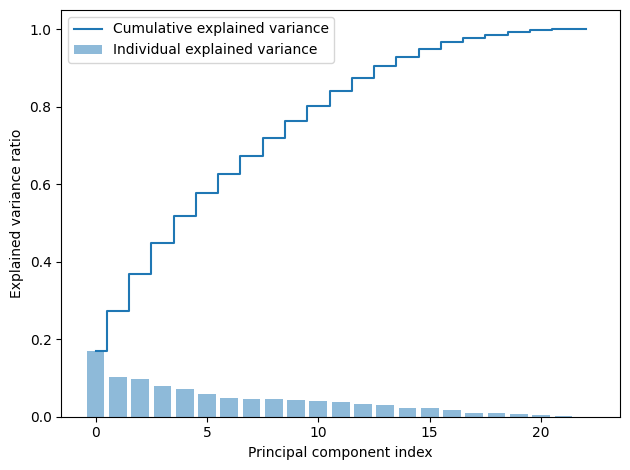

Number of components explaining 75% of variance: 10


In [11]:
scaler = StandardScaler()


# Standardize the data
df_standardized = scaler.fit_transform(df)
df_standardized = pd.DataFrame(df_standardized, columns=df.columns)
df_standardized.head()

# Fit the PCA
pca = PCA(n_components=df_standardized.shape[1])
pca.fit(df_standardized)

# Transform the data
x_new_cols = df_standardized.columns
x_new = pca.fit_transform(df_standardized)
# ----------------------------------------
# Explained variance ratio
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# ------------------------------------------

# Find index where cumulative explained variance is greater than 0.9
desidered_explained_variance = 0.75
index_selected = next(x[0] for x in enumerate(cum_sum_eigenvalues) if x[1] > desidered_explained_variance) + 1
print(f'Number of components explaining 75% of variance: {index_selected}')

#--------------------------------------------

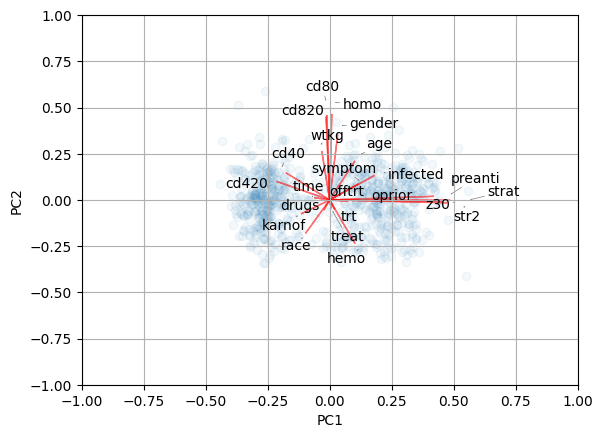

In [13]:
from adjustText import adjust_text

def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, alpha=0.05)
    
    texts = []
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        text = plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='black', ha='center', va='center')
        texts.append(text)
    
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), x_new_cols)
plt.show()
# --------------------------------------------

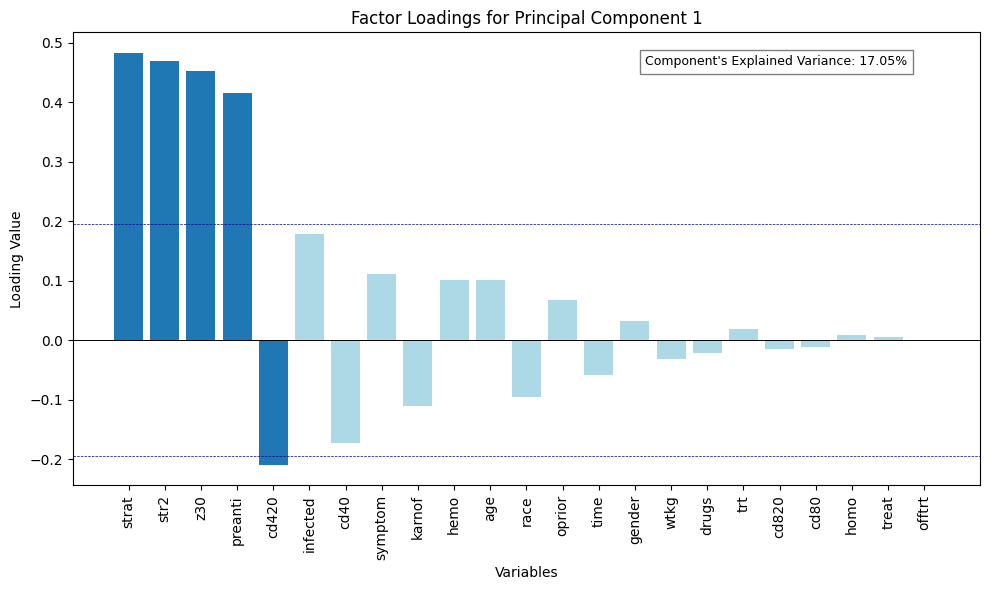

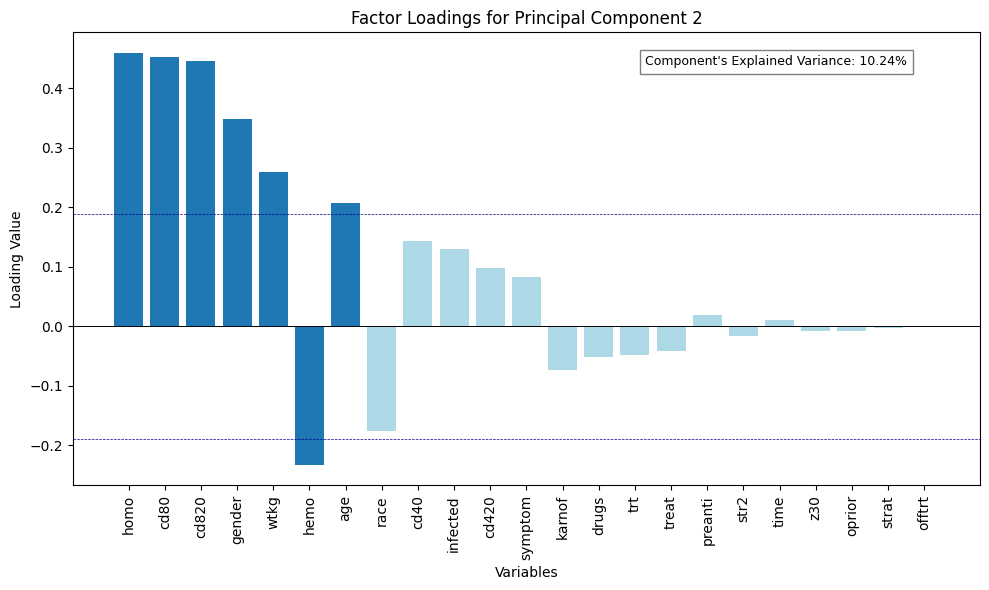

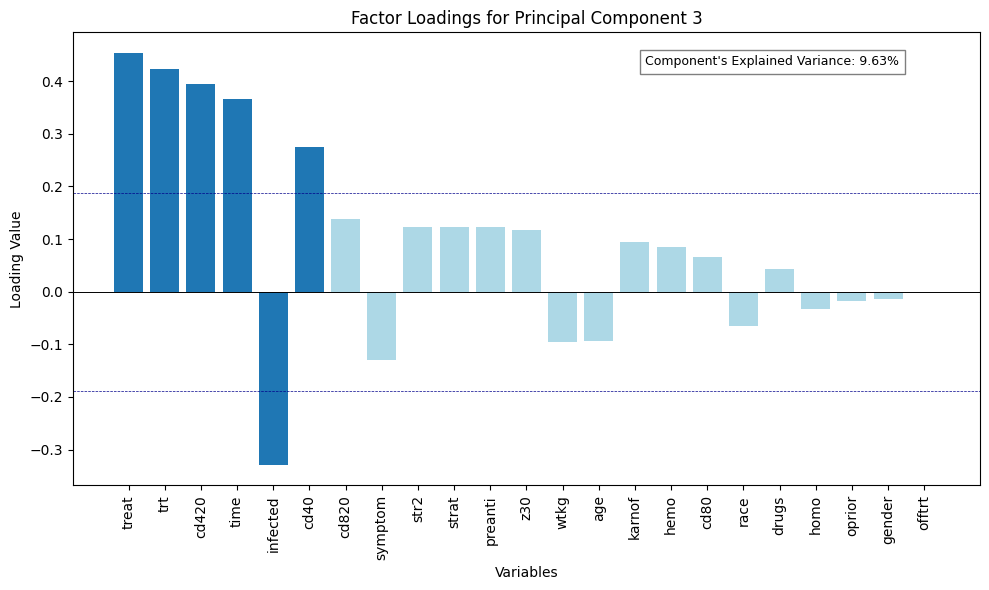

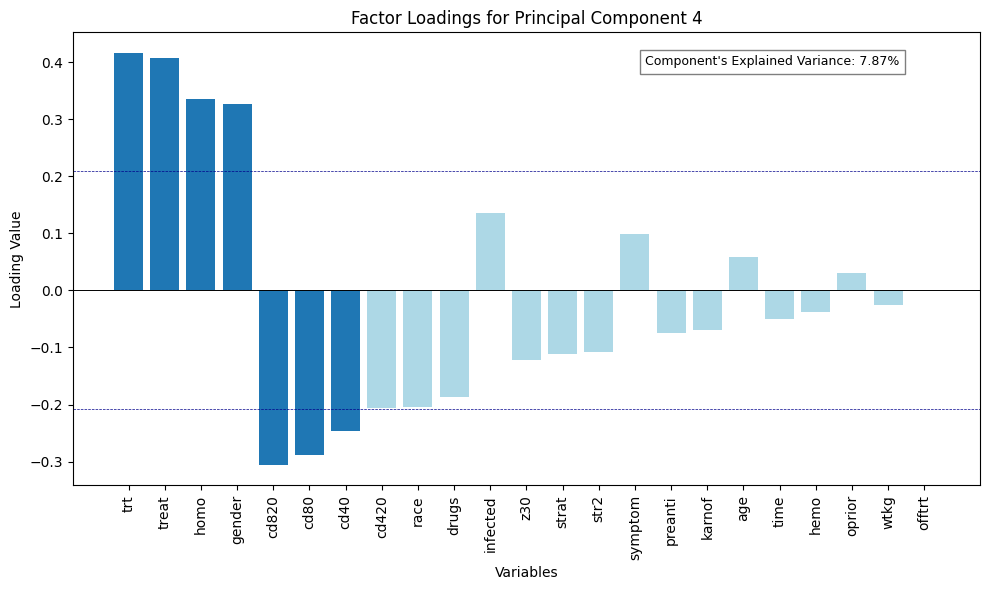

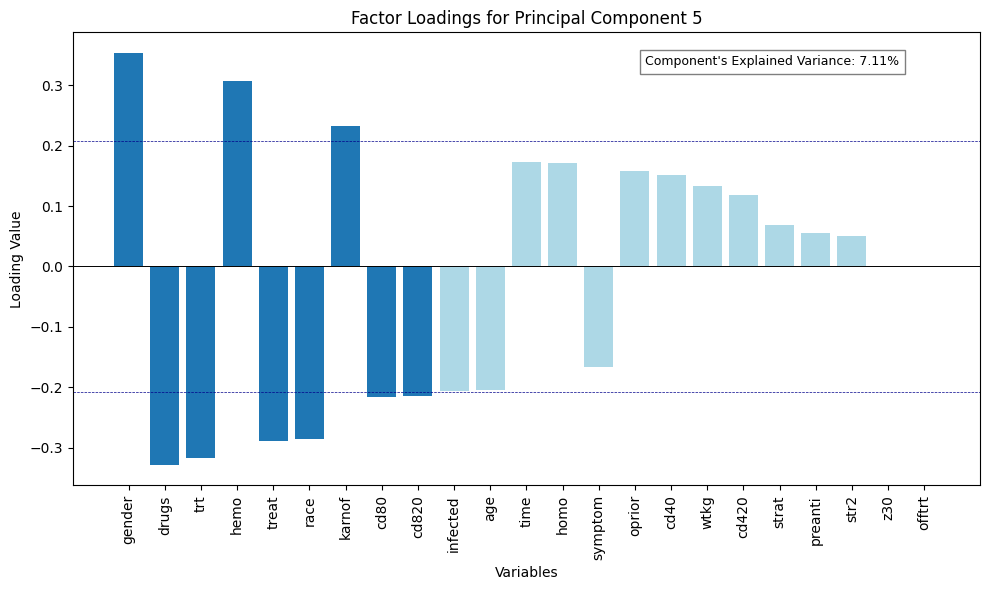

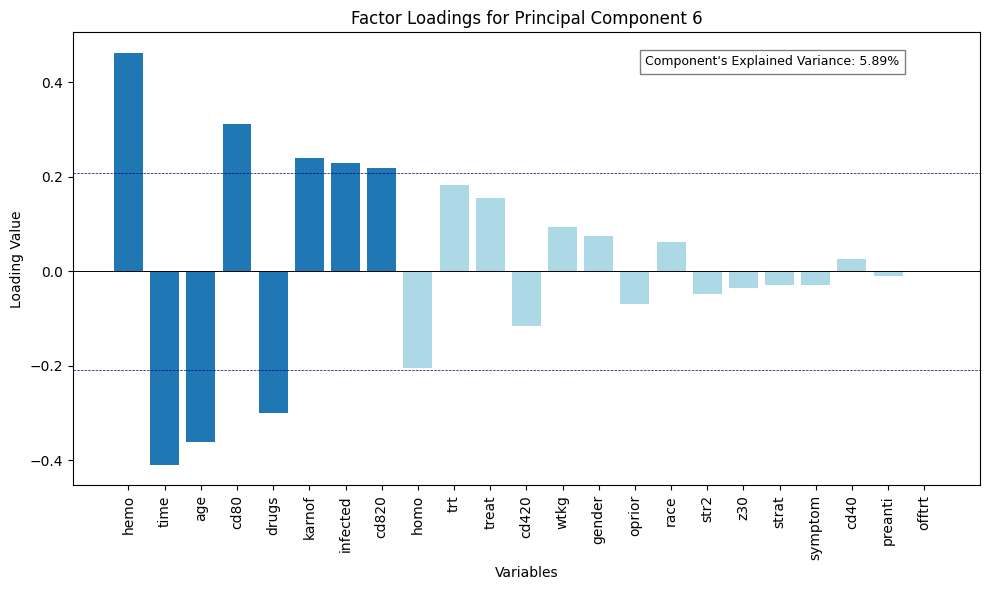

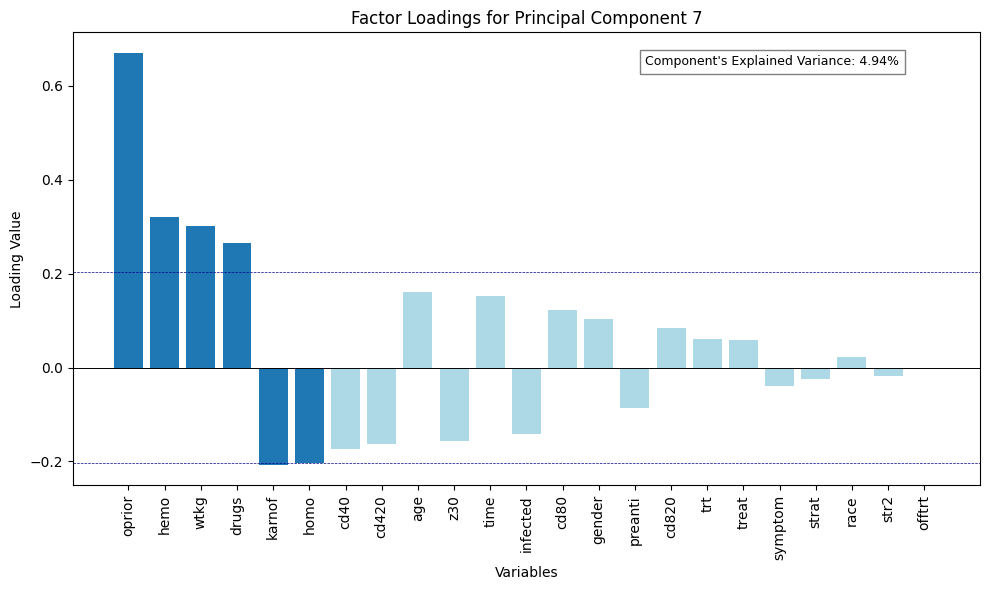

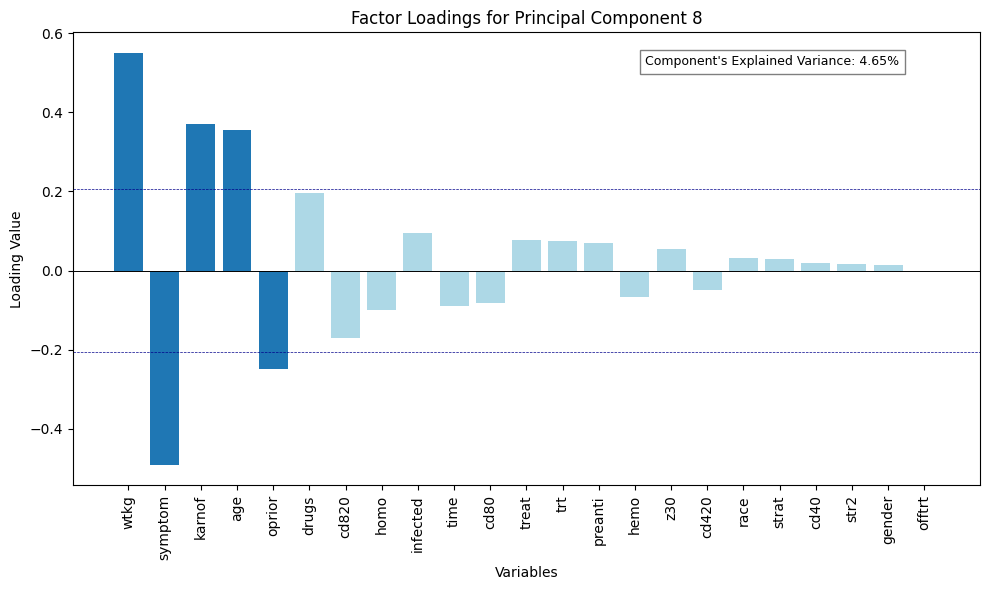

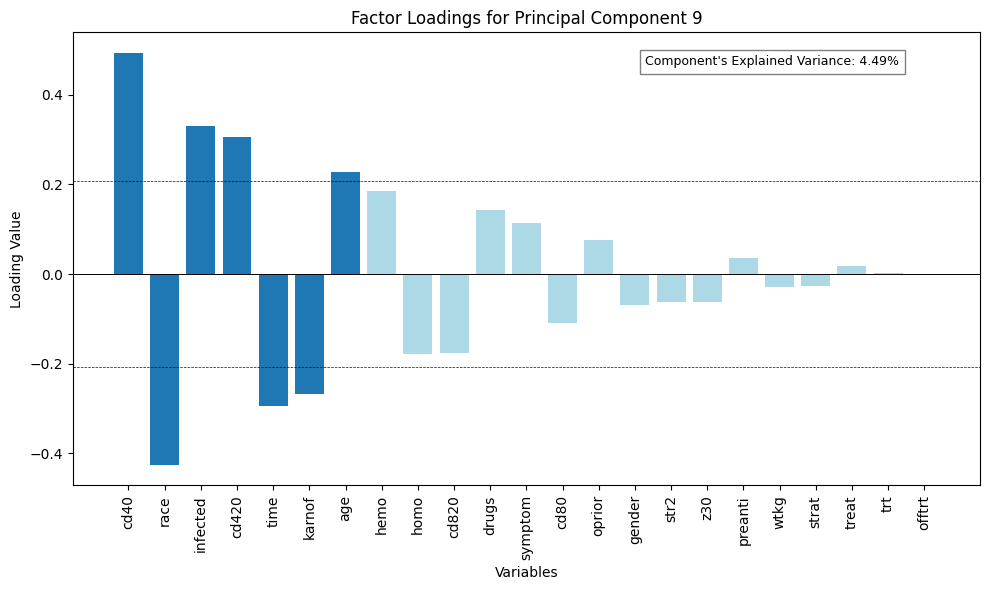

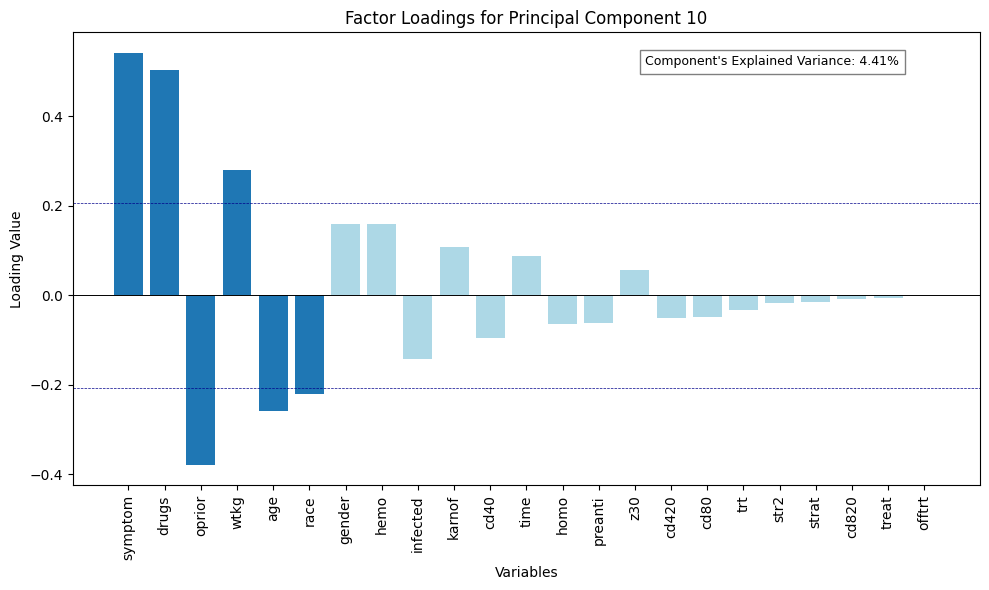

In [14]:
loadings = pca.components_.T

# Plotting the components to gain an explained variance threshold before defined
for i in range(index_selected): # range(loadings.shape[1]) to plot all components
    sorted_idx = np.argsort(abs(loadings[:, i]))[::-1]
    sorted_loadings = loadings[sorted_idx, i]
    vars = x_new_cols[sorted_idx]
    std_loading = np.std(sorted_loadings)
    
    # Colors based on comparison with the mean
    standart_blue = '#1f77b4'
    colors = [standart_blue if abs(loading) >= std_loading else 'lightblue' for loading in sorted_loadings]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_loadings)), sorted_loadings, color=colors)
    plt.title(f'Factor Loadings for Principal Component {i+1}')
    plt.xticks(range(len(sorted_loadings)), vars, rotation=90)
    plt.xlabel('Variables')
    plt.ylabel('Loading Value')
    plt.axhline(std_loading, color='darkblue', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='black', linewidth=0.7)

    if sorted_loadings.min() < std_loading * -1:
        plt.axhline(-std_loading, color='darkblue', linestyle='--', linewidth=0.5)
        
    explained_variance = exp_var_pca[i] * 100  # convert to percentage
    textstr = f"Component's Explained Variance: {explained_variance:.2f}%"
    # Place the text box in the upper left corner
    plt.gcf().text(0.65, 0.9, textstr, fontsize=9, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()
    

## Analyze offtrt patients with respect to specific covariates

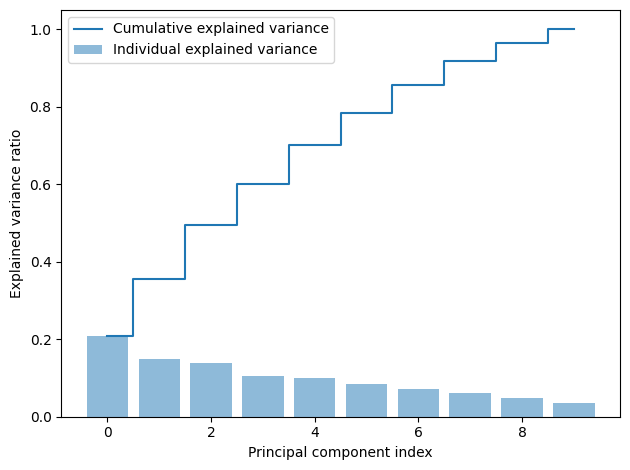

Number of components explaining 75% of variance: 6


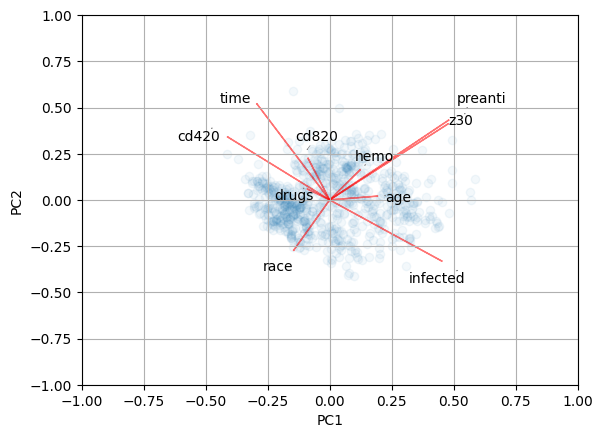

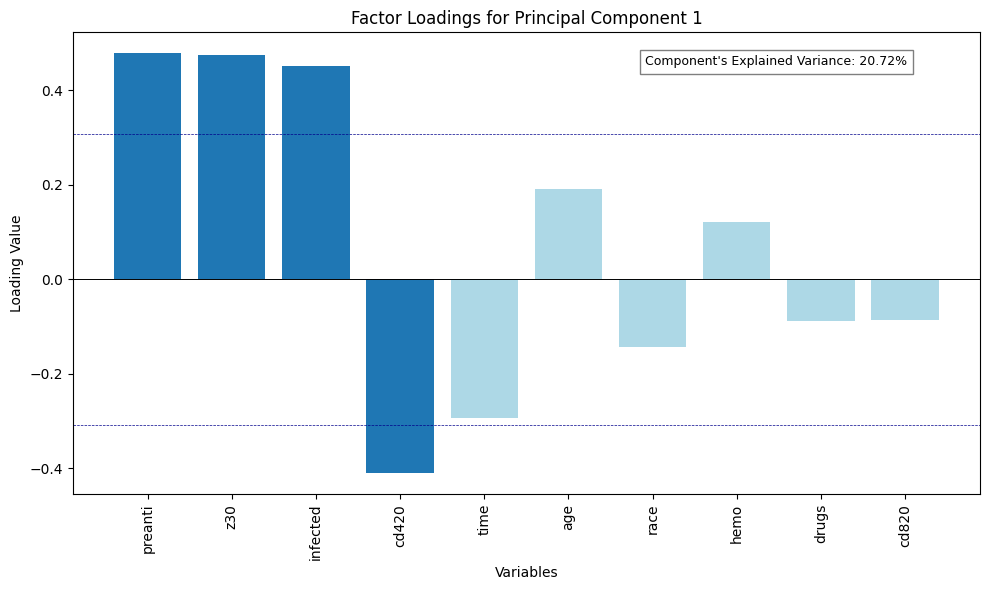

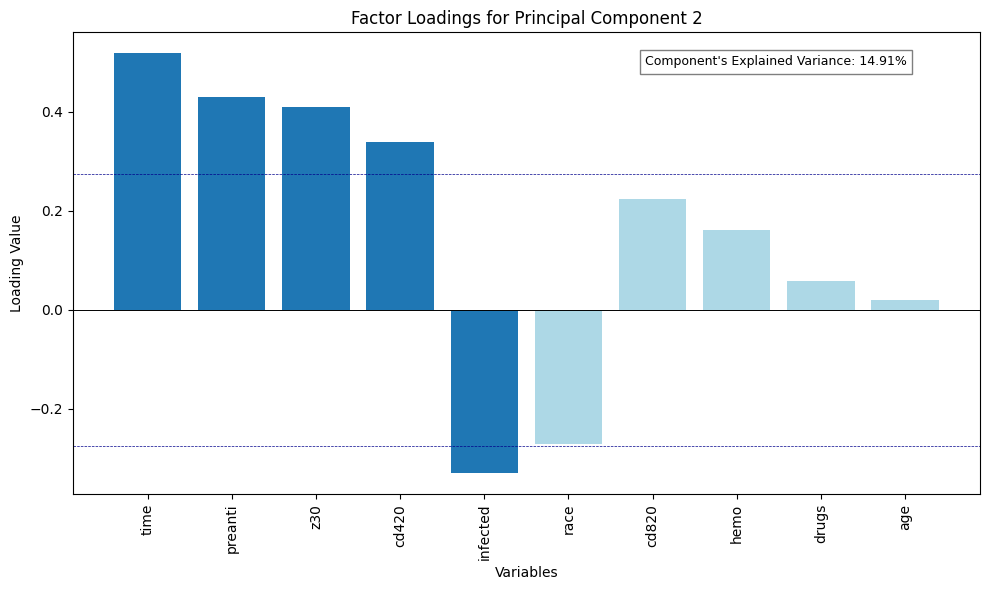

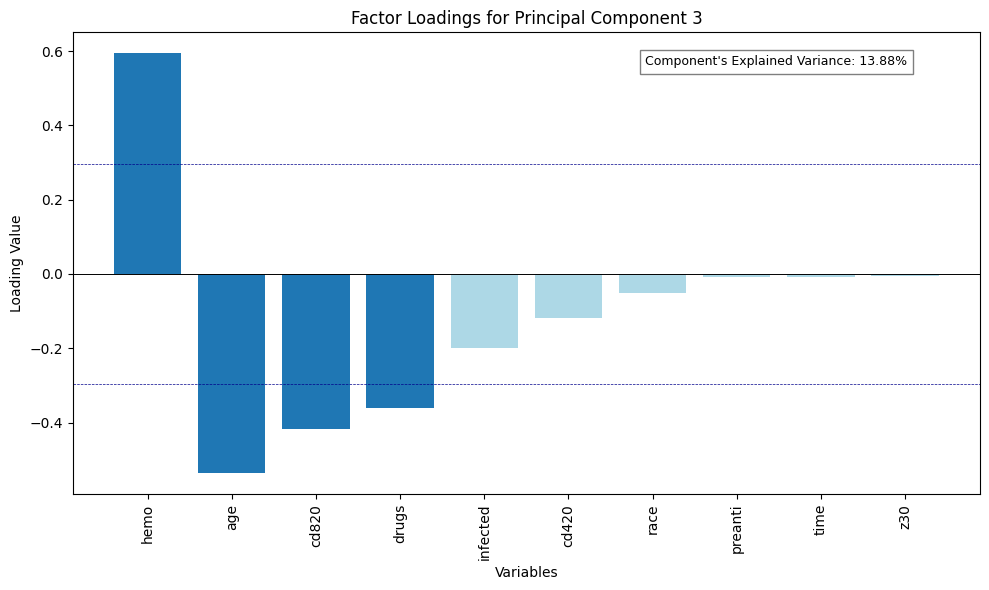

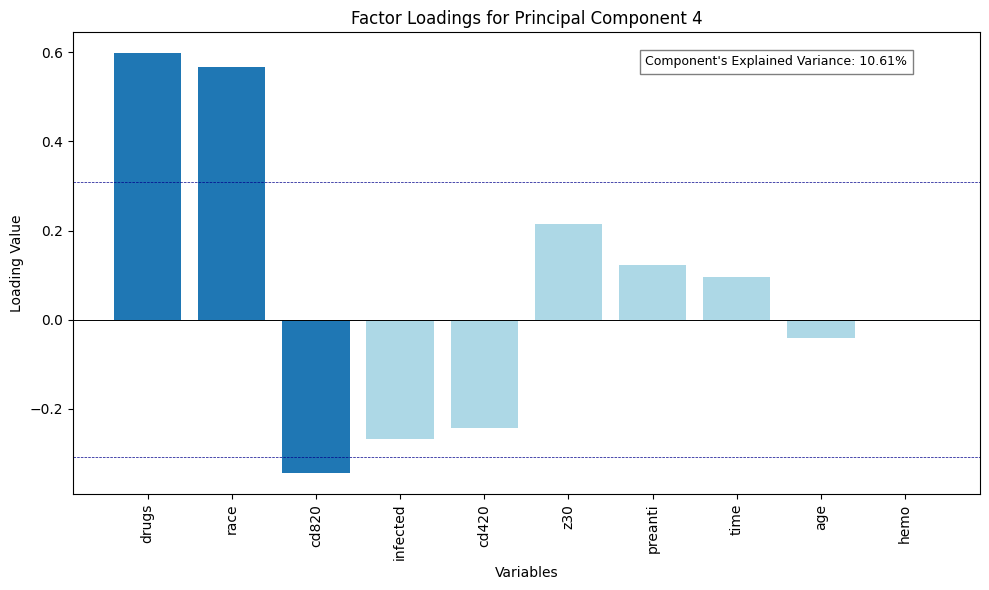

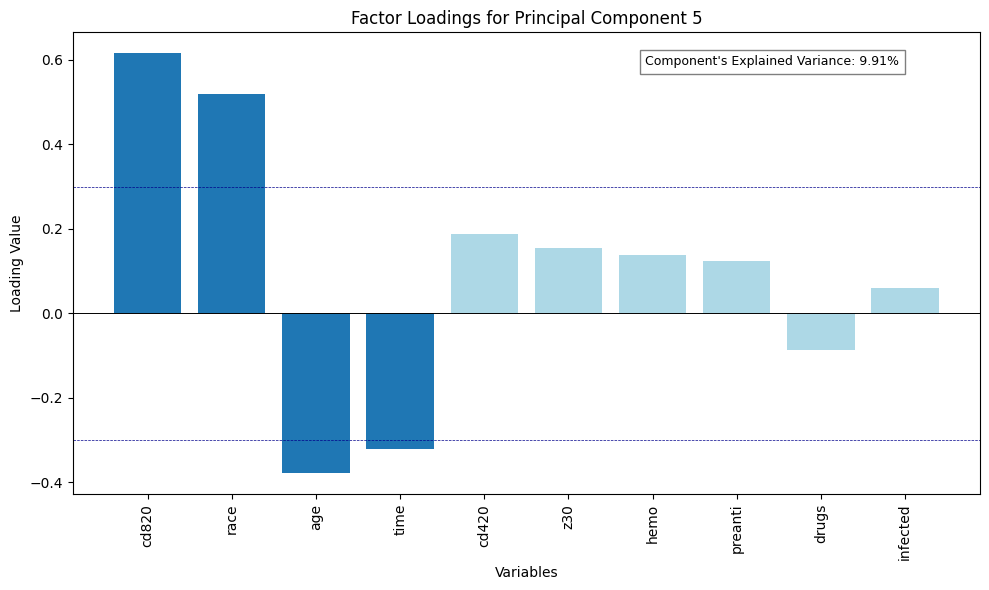

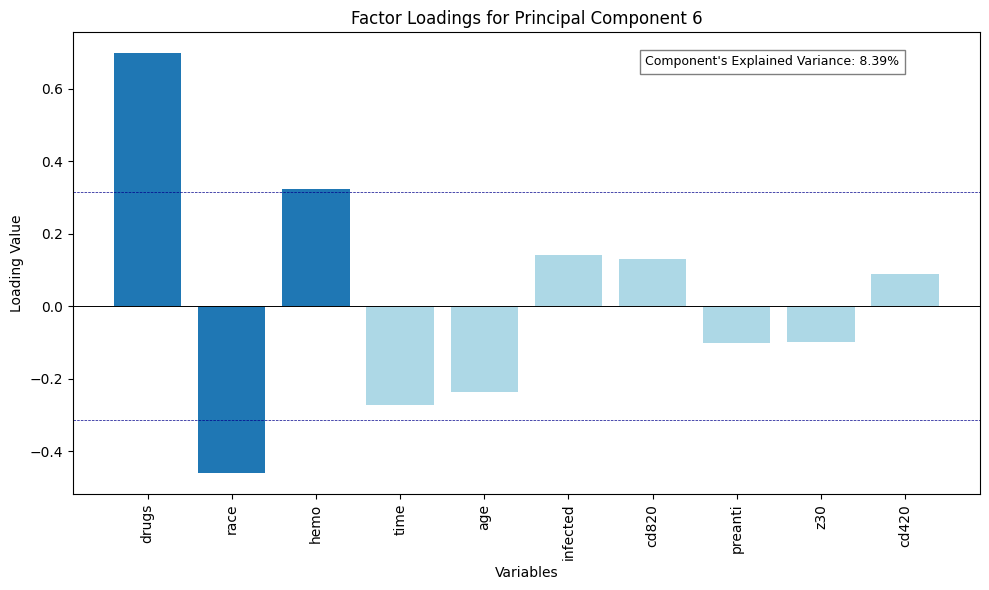

In [18]:
## Analyze the OFFTRT patients

covariates = "time cd420 hemo race drugs preanti z30 cd820 age infected".split()

df = data[covariates][data['offtrt']==1]

scaler = StandardScaler()


# Standardize the data
df_standardized = scaler.fit_transform(df)
df_standardized = pd.DataFrame(df_standardized, columns=df.columns)
df_standardized.head()

# Fit the PCA
pca = PCA(n_components=df_standardized.shape[1])
pca.fit(df_standardized)

# Transform the data
x_new_cols = df_standardized.columns
x_new = pca.fit_transform(df_standardized)
# ----------------------------------------
# Explained variance ratio
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# ------------------------------------------

# Find index where cumulative explained variance is greater than 0.9
desidered_explained_variance = 0.75
index_selected = next(x[0] for x in enumerate(cum_sum_eigenvalues) if x[1] > desidered_explained_variance) + 1
print(f'Number of components explaining 75% of variance: {index_selected}')


#Call the function myplot. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), x_new_cols)
plt.show()
# --------------------------------------------
loadings = pca.components_.T

# Plotting the components to gain an explained variance threshold before defined
for i in range(index_selected): # range(loadings.shape[1]) to plot all components
    sorted_idx = np.argsort(abs(loadings[:, i]))[::-1]
    sorted_loadings = loadings[sorted_idx, i]
    vars = x_new_cols[sorted_idx]
    std_loading = np.std(sorted_loadings)
    
    # Colors based on comparison with the mean
    standart_blue = '#1f77b4'
    colors = [standart_blue if abs(loading) >= std_loading else 'lightblue' for loading in sorted_loadings]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_loadings)), sorted_loadings, color=colors)
    plt.title(f'Factor Loadings for Principal Component {i+1}')
    plt.xticks(range(len(sorted_loadings)), vars, rotation=90)
    plt.xlabel('Variables')
    plt.ylabel('Loading Value')
    plt.axhline(std_loading, color='darkblue', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='black', linewidth=0.7)

    if sorted_loadings.min() < std_loading * -1:
        plt.axhline(-std_loading, color='darkblue', linestyle='--', linewidth=0.5)
        
    explained_variance = exp_var_pca[i] * 100  # convert to percentage
    textstr = f"Component's Explained Variance: {explained_variance:.2f}%"
    # Place the text box in the upper left corner
    plt.gcf().text(0.65, 0.9, textstr, fontsize=9, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()
    
